In [1]:
import os
os.chdir("../../")

In [2]:
import sqlite3
import pandas as pd
from api.utils.database import rows_to_dicts


In [3]:
con = sqlite3.connect("./pipeline/database.db")


Compare 2017 and 2018 rent-burden rates
tables: rent_burdened, belonging, community_areas
columns: years, area_number, value
joins: self-join with both rent_burden and belonging

In [11]:
cur = con.cursor()

rows = cur.execute("""
SELECT 
    rent_2018.area_number, 
    rent_2017.value AS rb_rate_2017, 
    rent_2018.value AS rb_rate_2018,
    belonging_2017.value as belonging_rate_2017,
    belonging_2018.value as belonging_rate_2018,
    rent_2018.value - rent_2017.value as rb_change,
    belonging_2018.value - belonging_2017.value as belonging_change
FROM (
    SELECT * 
    FROM rent_burdened_households
    WHERE period_end_year=2017
    AND segment="all"
) rent_2017 
LEFT JOIN (
    SELECT * 
    FROM rent_burdened_households
    WHERE period_end_year=2018
    AND segment="all"
) rent_2018
    ON rent_2017.area_number = rent_2018.area_number
LEFT JOIN (
    SELECT * 
    FROM belonging
    WHERE period_end_year=2017
    AND segment="all"
) belonging_2017
    ON rent_2017.area_number = belonging_2017.area_number
LEFT JOIN (
    SELECT * 
    FROM belonging
    WHERE period_end_year=2018
    AND segment="all"
) belonging_2018
    ON rent_2017.area_number = belonging_2018.area_number
""").fetchall()


df = pd.DataFrame(rows_to_dicts(cur, rows))
df

,rent_2018.area_number,rb_rate_2017,rb_rate_2018,belonging_rate_2017,belonging_rate_2018,rb_change,belonging_change
0,35,54.563723,55.095746,63.9,59.4,0.532023,-4.5
1,36,44.265608,46.408286,56.1,65.6,2.142678,9.5
2,37,63.299689,54.107734,40.5,44.5,-9.191955,4.0
3,38,53.594809,53.017306,57.0,56.1,-0.577503,-0.9
4,39,50.342665,49.536452,73.2,78.1,-0.806213,4.9
...,...,...,...,...,...,...,...
72,74,28.733377,34.609594,79.2,81.0,5.876217,1.8
73,75,49.957435,50.641984,69.8,67.5,0.684549,-2.3
74,76,44.142648,44.837730,56.2,72.1,0.695082,15.9
75,77,44.958700,43.562715,71.3,70.5,-1.395985,-0.8


In [6]:
import seaborn as sns

<AxesSubplot:xlabel='rb_change', ylabel='belonging_change'>

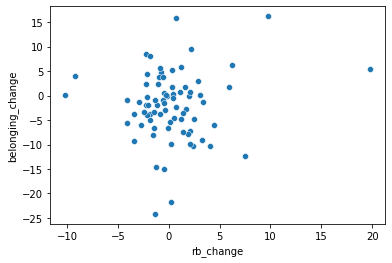

In [15]:
sns.scatterplot(x=df["rb_change"],y=df["belonging_change"])

Compare the rate of belonging to the number of rideshare pickups divided by population. 
That is, the number of rideshare pickups per day in each area divided by that area's population
Should show area_number, 
population, 
number of rideshare pickups per day, 
belonging rate of that area, 
and the rideshares per day divded by population

In [10]:
cur = con.cursor()

rows = cur.execute("""
SELECT 
    rideshare_2018.area_number AS area_number,
    population_2018.value AS area_population,
    rideshare_2018.value / 365 AS rs_per_day_2018,
    belonging_2018.value AS belonging_rate_2018,
    ((rideshare_2018.value/365) / population_2018.value) AS rideshare_by_population
FROM (
    SELECT 
        pickup_community_area as area_number,
        sum(n_trips) as value,
        strftime('%Y', week) as period_end_year
    FROM rideshare
    WHERE period_end_year = '2018'
    GROUP BY area_number
) rideshare_2018 
LEFT JOIN (
    SELECT * 
    FROM belonging
    WHERE period_end_year=2018
    AND segment="all"
) belonging_2018
    ON rideshare_2018.area_number = belonging_2018.area_number
LEFT JOIN (
    SELECT *
    FROM population
    WHERE period_end_year=2018
    AND segment="all"
) population_2018
    ON rideshare_2018.area_number = population_2018.area_number
""").fetchall()


df = pd.DataFrame(rows_to_dicts(cur, rows))
df

,area_number,area_population,rs_per_day_2018,belonging_rate_2018,rideshare_by_population
0,1,51985.015213,431,63.1,0.008291
1,2,77194.756599,313,58.8,0.004055
2,3,53226.524065,994,64.4,0.018675
3,4,41642.093835,474,64.6,0.011383
4,5,35767.842260,568,74.8,0.015880
...,...,...,...,...,...
72,73,27247.601967,92,63.2,0.003376
73,74,19348.889650,23,81.0,0.001189
74,75,22225.163841,61,67.5,0.002745
75,76,15414.729559,813,72.1,0.052742


<AxesSubplot:xlabel='belonging_rate_2018', ylabel='rideshare_by_population'>

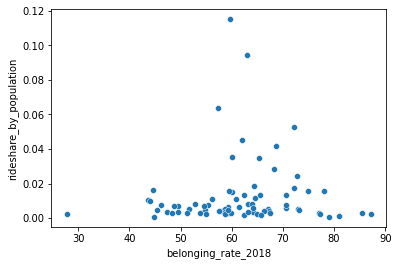

In [11]:
sns.scatterplot(x=df["belonging_rate_2018"],y=df["rideshare_by_population"])